In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2


In [2]:
# Here perform one analysis based on the best optimization parameters
# Load dataset from npz files
dict_X = np.load('../dataset/X.npz')
dict_y = np.load('../dataset/y.npz')
# Store arrays from dictionary
X = dict_X['arr_0']
y = dict_y['arr_0']

In [3]:
# data split training/test sets for cross-validations
cv_splits = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

In [4]:
# pipeline of k-PCA with scaler and SVM for cross-validation over different training/test samples

# initialize k-PCA with 50 modes (to get maximize accuracy)
n_kPCA = 50
gamma_rbf = 5e-11
kPCA = KernelPCA(n_components=n_kPCA, kernel='rbf', gamma=gamma_rbf, random_state=42, eigen_solver='arpack')
# initialize SVM with Radial Basis Functions (rbf) and balanced weights (although dataset is pretty balanced)
# parameters C and gamma are taken from previous analysis:
# {'svc__C': 35000, 'svc__gamma': 0.03}
sv_clf = SVC(kernel='rbf', class_weight='balanced', C=35000, gamma=0.03)

In [5]:
# Combine k-PCA with a standard scaler
scaler = StandardScaler()
scale_kPCA = make_pipeline(kPCA, scaler)
# Now the model brings together (kPCA with unit variance) and the SVM classiffier
model = make_pipeline(scale_kPCA, sv_clf)

In [6]:
# cross-validation over train/test samples with k-PCA transformation into SVM classifier
%time cv_kPCA_50_svm = cross_val_score(model, X, y, cv=cv_splits)

Wall time: 33.2 s


In [7]:
cv_kPCA_50_svm.mean()

0.9175496688741722

In [8]:
# Final results!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('kernelpca',
                                  KernelPCA(alpha=1.0, coef0=1, copy_X=True,
                                            degree=3, eigen_solver='arpack',
                                            fit_inverse_transform=False,
                                            gamma=5e-11, kernel='rbf',
                                            kernel_params=None, max_iter=None,
                                            n_components=50, n_jobs=None,
                                            random_state=42,
                                            remove_zero_eig=False, tol=0)),
                                 ('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True))],
                          verbose=False)),
                ('svc',
             

In [9]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred,normalize='true')
np.diag(cm).min()

0.625

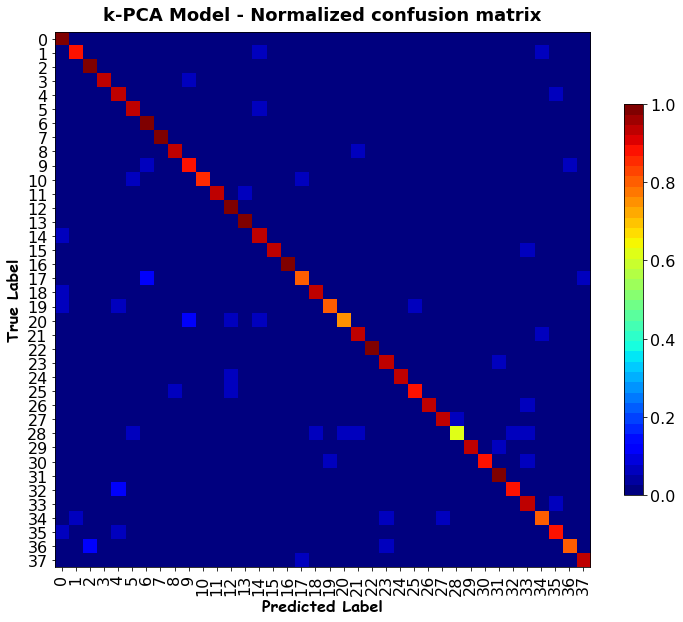

In [10]:
# Plot normalized confusion matrix
fig = plt.figure(figsize=[12,12])
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
disp = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.get_cmap('jet', 38),normalize='true',ax=ax1,include_values=False)
disp.ax_.set_title('k-PCA Model - Normalized confusion matrix', size=18, weight='bold',y=1.01)
label_prop = {'size':16,'weight':'bold','family':'fantasy'}
disp.ax_.set_xlabel('Predicted Label',fontdict=label_prop)
disp.ax_.set_ylabel('True Label',fontdict=label_prop)

xylabels = np.arange(0,38,1)
disp.ax_.set_yticks(xylabels)
disp.ax_.tick_params(axis='y', labelsize=16)
disp.ax_.set_xticks(xylabels)
disp.ax_.tick_params(axis='x', labelsize=16,rotation=90)

ax1.images[-1].colorbar.remove()
cbar = plt.colorbar(disp.im_, shrink=0.6)
cbar.ax.tick_params(labelsize=16)

# fig.savefig('../images/conf_mat_kPCA.png',dpi=800,bbox_inches='tight')

In [11]:
df_results = pd.DataFrame.from_dict(classification_report(y_test, y_pred,output_dict=True)).T
df_results.drop(['accuracy','macro avg','weighted avg'], axis=0,inplace=True)
df_results.drop(['support'], axis=1,inplace=True)

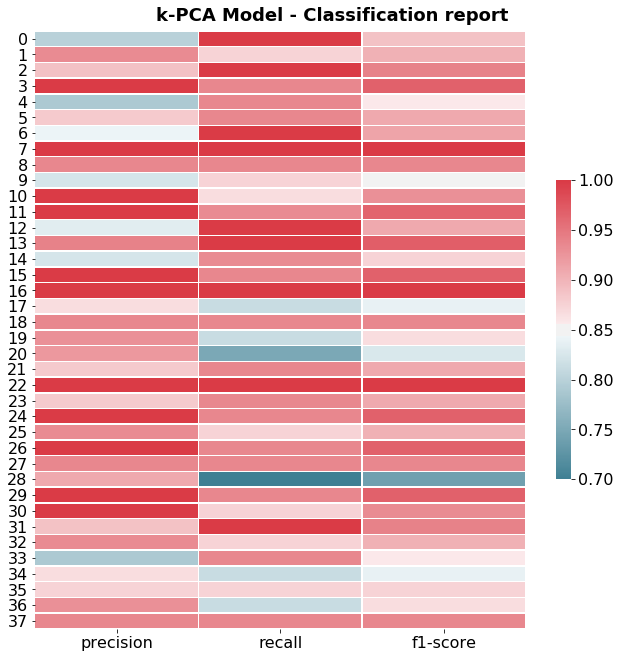

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

f.suptitle('k-PCA Model - Classification report', size=18, weight='bold',y=0.91)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(df_results, cmap=cmap, vmin=0.7, vmax=1, center=0.85,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16,rotation=0)
# use matplotlib.colorbar.Colorbar object
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)

# f.savefig('../images/class_rep_kPCA.png',dpi=800,bbox_inches='tight')


In [48]:
pic_pred

array([18, 18, 19, 21,  9, 16, 24,  2], dtype=int64)

In [49]:
y_test[p_sel]

array([18, 18, 19,  8, 20, 16, 24, 36], dtype=int64)

In [21]:
# Load picture referece for people
dict_Xref = np.load('../dataset/X_ref.npz')
# Store arrays from dictionary
X_ref = dict_Xref['arr_0']

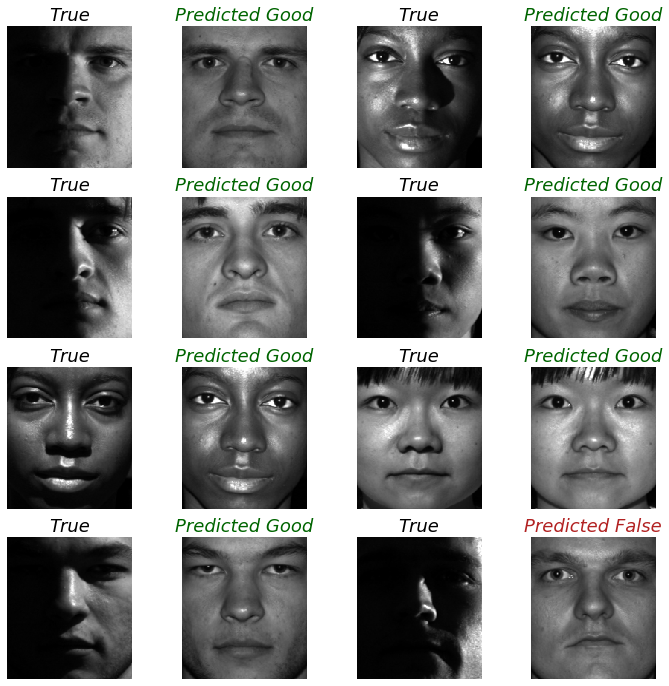

In [50]:
# create nice subplot with images of people!
# np.random.seed(seed=15)
p_sel = np.random.randint(X_test.shape[0], size=8)
pic_pred = model.predict(X_test[p_sel,:])

# prepare figure
fig = plt.figure(figsize=[12,12])
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
subtitle_prop_good = {'size':18,'style':'oblique','color':'darkgreen'}
subtitle_prop_false = {'size':18,'style':'oblique','color':'firebrick'}

for i in range(16):
    row = int(np.floor(i/4))
    col = i%4
    axis = fig.add_subplot(spec[row,col])
    plt.axis('off')
    
    if i%2 == 0:
        axis.set_title('True',fontdict=subtitle_prop)
        plt_image = cv2.cvtColor(X_test[p_sel[int(i/2)],:].reshape(192,-1), cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(plt_image)
    else:
        if pic_pred[int(i/2)] == y_test[p_sel[int(i/2)]]:
            label = 'Predicted Good'
            axis.set_title(label,fontdict=subtitle_prop_good)
        else:
            label = 'Predicted False'
            axis.set_title(label,fontdict=subtitle_prop_false)
        plt_image = cv2.cvtColor(X_ref[pic_pred[int(i/2)]].reshape(192,-1), cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(plt_image)

fig.savefig('../images/predic_test.png',dpi=800,bbox_inches='tight')